# Facies classification using Machine Learning- Majority voting

Contest entry by Priyanka Raghavan and Steve Hall

This notebook demonstrates how to train a machine learning algorithm to predict facies from well log data.  The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core.  We will use this log data to train a support vector machine to classify facies types.  We will use simple logistics regression to classify wells [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

First we will [explore the dataset](#Exploring-the-dataset).  We will load the training data from 9 wells, and take a look at what we have to work with.  We will plot the data from a couple wells, and create cross plots to look at the variation within the data.  

Next we will [condition the data set](#Conditioning-the-data-set).  We will remove the entries that have incomplete data.  The data will be scaled to have zero mean and unit variance.  We will also split the data into training and test sets.

We will then be ready to [build the classifier](#Building-the-classifier).  

Finally, once we have a built and tuned the classifier, we can [apply the trained model](#Applying-the-classification-model-to-new-data) to classify facies in wells which do not already have labels.  We will apply the classifier to two wells, but in principle you could apply the classifier to any number of wells that had the same log data.

## Exploring the dataset

First, we will examine the data set we will use to train the classifier.  The training data is contained in the file `facies_vectors.csv`.  The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals.  In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).  We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

In [66]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = 'facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [67]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

In [68]:
training_data.describe()

F:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,NaN,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,NaN,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,NaN,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables.  Looking at the `count` values, there are 3232 feature vectors in the training set.

Remove a single well to use as a blind test later. For that let us look at distribution of facies across wells

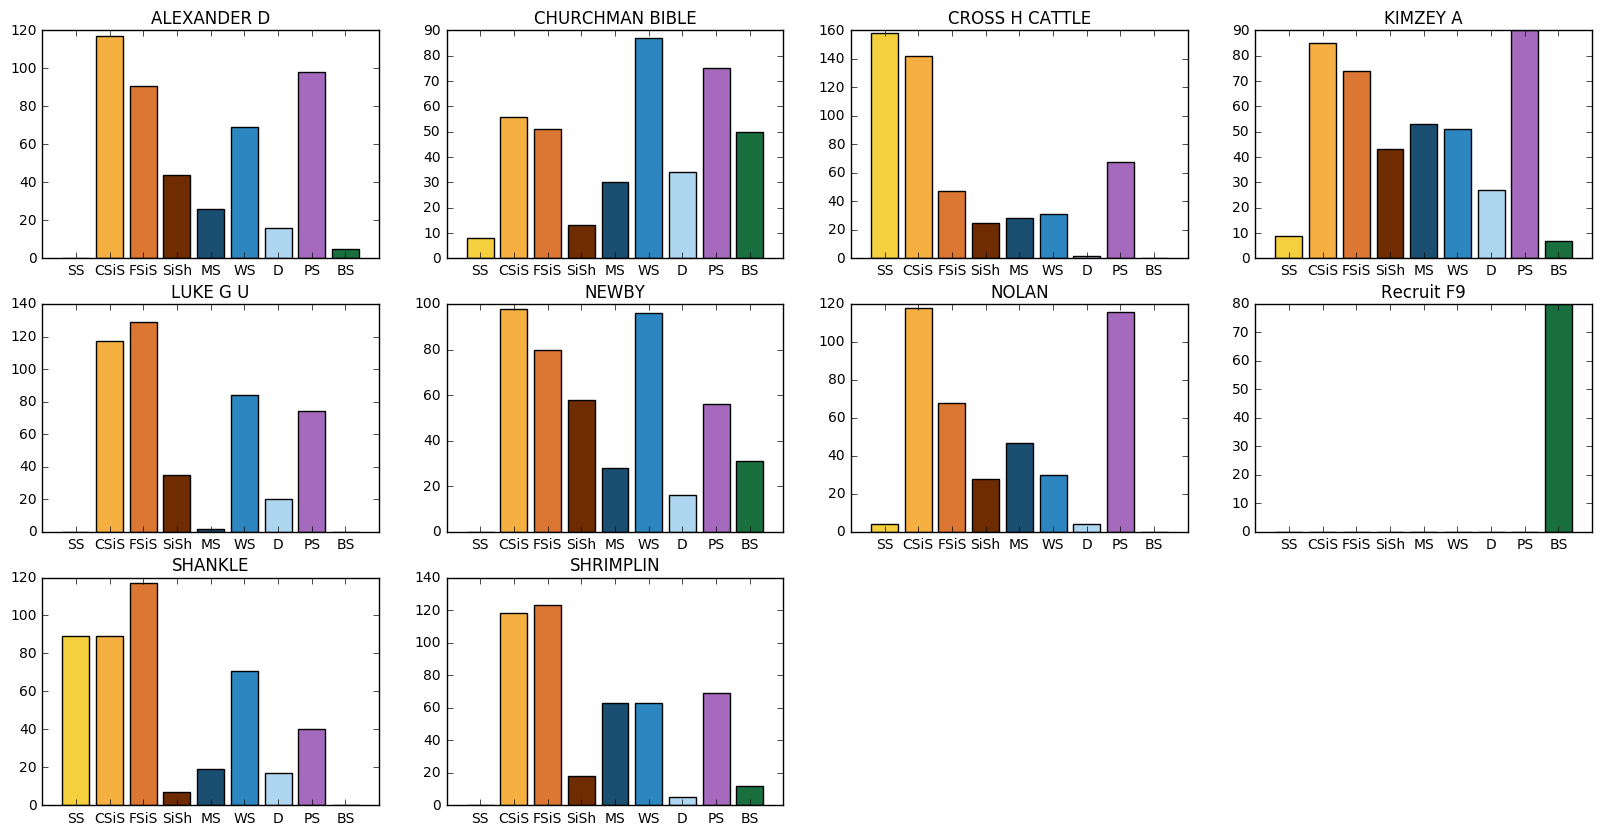

In [69]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
#training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
faciesVals = training_data['Facies'].values 
well = training_data['Well Name'].values
mpl.rcParams['figure.figsize'] = (20.0, 10.0)
for w_idx, w in enumerate(np.unique(well)):    
    ax = plt.subplot(3, 4, w_idx+1)
    hist = np.histogram(faciesVals[well == w], bins=np.arange(len(facies_labels)+1)+.5)
    plt.bar(np.arange(len(hist[0])), hist[0], color=facies_colors, align='center')
    ax.set_xticks(np.arange(len(hist[0])))
    ax.set_xticklabels(facies_labels)
    ax.set_title(w)


Based on graphs above NEWBY has a good distribution of wells and is taken out as blind well to be tested. Also since training data has null, remove them from data.

In [70]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]
blind = training_data[training_data['Well Name'] == 'NEWBY']
training_data = training_data[training_data['Well Name'] != 'NEWBY']
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

Let's take a look at the data from individual wells in a more familiar log plot form.  We will create plots for the five well log variables, as well as a log for facies labels.  The plots are based on the those described in Alessandro Amato del Monte's [excellent tutorial](https://github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1).

In [71]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells.  The function was written to take a list of colors and facies labels as parameters.  

We then show log plots for wells `SHRIMPLIN`.  

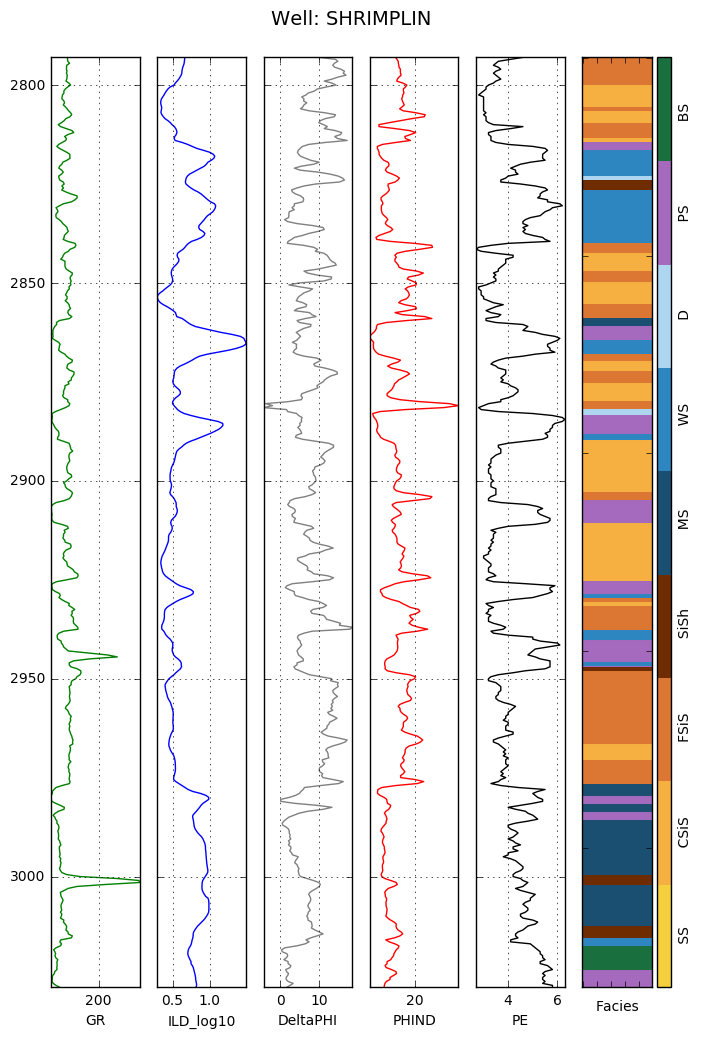

In [72]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histogram of the number of training examples for each facies class.

SS      259
CSiS    640
FSiS    535
SiSh    126
MS      189
WS      366
D        82
PS      442
BS      130
Name: Facies, dtype: int64

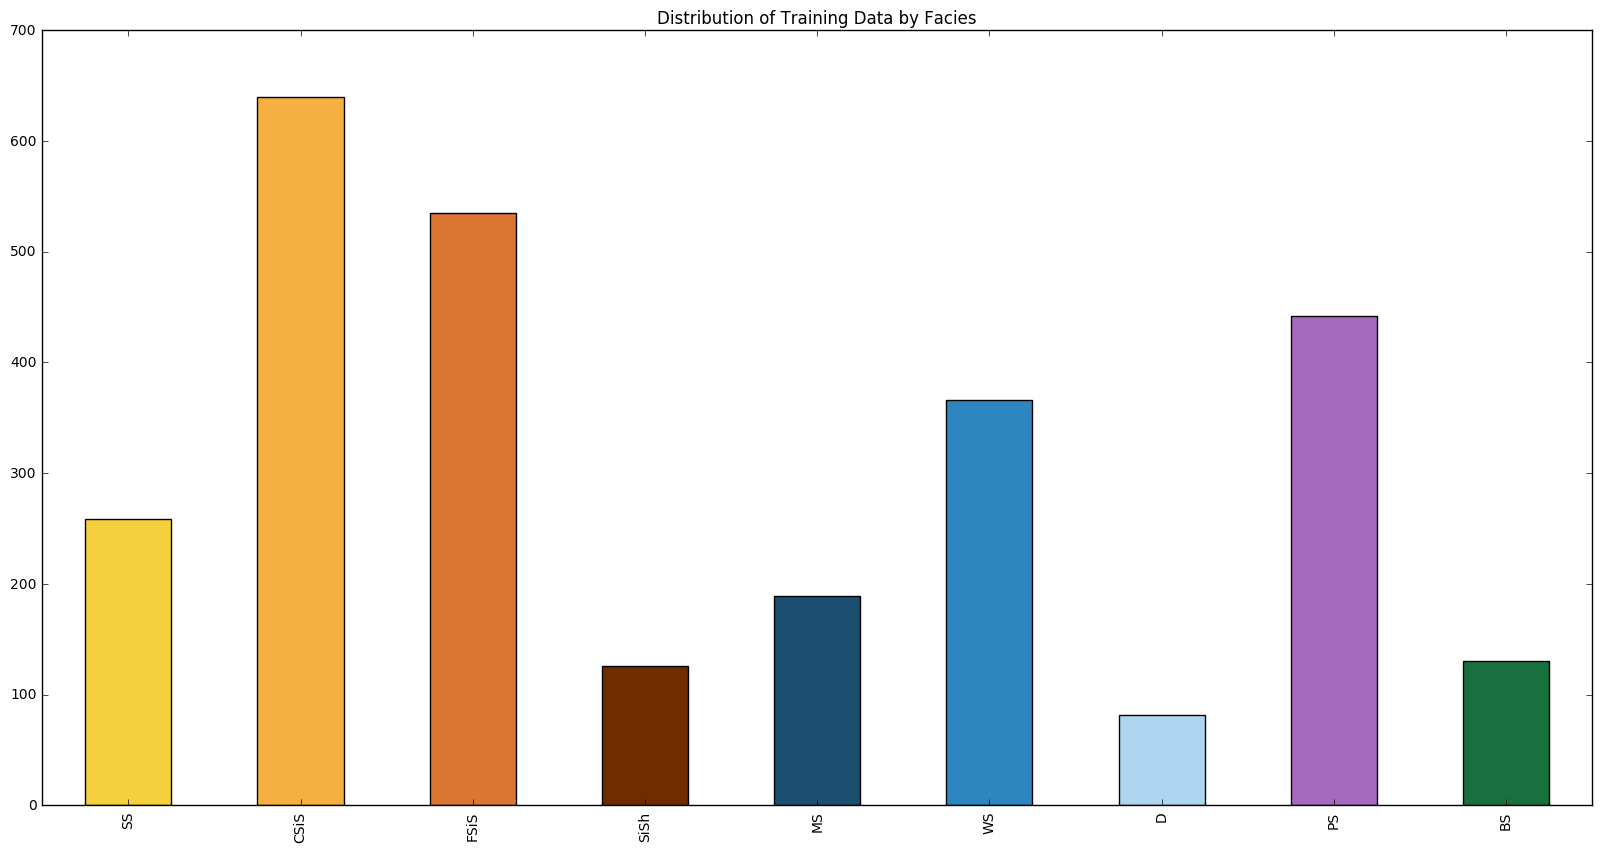

In [73]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

This shows the distribution of examples by facies for the examples in the training set.  Dolomite (facies 7) has the fewest with 81 examples.  Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.
 

## Conditioning the data set

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [74]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000
mean,67.039150,0.637353,3.573298,13.793859,3.717207,1.478873,0.518975
std,30.280378,0.250915,5.270749,8.007659,0.943923,0.499644,0.287105
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,48.125000,0.479863,1.211000,8.450000,3.078000,1.000000,0.269000
50%,66.910000,0.621903,3.500000,12.337000,3.500000,1.000000,0.526000
75%,80.594000,0.819000,6.400000,16.795000,4.371000,2.000000,0.767000
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


Scikit includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data (giving each variable zero mean and unit variance, also called *whitening*).  Many machine learning algorithms assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance).  The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier.  The `StandardScalar` class can be fit to the training set, and later used to standardize any training data.

In [75]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [76]:
feature_vectors

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,78.260,0.661,14.200,12.565,4.100,1,0.979
2,79.050,0.658,14.800,13.050,3.600,1,0.957
3,86.100,0.655,13.900,13.115,3.500,1,0.936
4,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...
4144,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,51.469,0.965,3.083,7.708,3.152,2,0.661


Scikit also includes a handy function to randomly split the training data into training and test sets.  The test set contains a small subset of feature vectors that are not used to train the network.  Because we know the true facies labels for these examples, we can compare the results of the classifier to the actual facies and determine the accuracy of the model.  Let's use 20% of the data for the test set.

In [78]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

## Training the classifier using Majority voting

Now we use the cleaned and conditioned training set to create a facies classifier.  As mentioned above, we will use a type of machine learning model known as a [Majority voting](https://en.wikipedia.org/wiki/Weighted_Majority_Algorithm).  
We trained classifier on four models KNeighbours, Random forest, logistic regression and Gradient boosting.
 




In [79]:

from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=10,weights='distance',algorithm='kd_tree')
clf.fit(X_train,y_train)
predicted_labels = clf.predict(X_test)

Now that the model has been trained on our data, we can use it to predict the facies of the feature vectors in the test set.  Because we know the true facies labels of the vectors in the test set, we can use the results to evaluate the accuracy of the classifier.

We need some metrics to evaluate how good our classifier is doing.  A [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) is a table that can be used to describe the performance of a classification model.  [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) allows us to easily create a confusion matrix by supplying the actual and predicted facies labels.

The confusion matrix is simply a 2D array.  The entries of confusion matrix `C[i][j]` are equal to the number of observations predicted to have facies `j`, but are known to have facies `i`.  

To simplify reading the confusion matrix, a function has been written to display the matrix along with facies labels and various error metrics.  See the file `classification_utilities.py` in this repo for the `display_cm()` function.

In [80]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    39     9                                              48
     CSiS     3   116    20                 1                     140
     FSiS     4    20    72           2     1           2         101
     SiSh                      21           5           2          28
       MS     1           1     1    27     6           4          40
       WS                 1     4     4    49     1     6     1    66
        D                                        10     3     1    14
       PS                 1     3     7    14     1    59     6    91
       BS                                                    26    26


The rows of the confusion matrix correspond to the actual facies labels.  The columns correspond to the labels assigned by the classifier.  For example, consider the first row. For the feature vectors in the test set that actually have label `SS`, 23 were correctly indentified as `SS`, 21 were classified as `CSiS` and 2 were classified as `FSiS`.

The entries along the diagonal are the facies that have been correctly classified.  Below we define two functions that will give an overall value for how the algorithm is performing.  The accuracy is defined as the number of correct classifications divided by the total number of classifications.

In [81]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

As noted above, the boundaries between the facies classes are not all sharp, and some of them blend into one another.  The error within these 'adjacent facies' can also be calculated.  We define an array to represent the facies adjacent to each other.  For facies label `i`, `adjacent_facies[i]` is an array of the adjacent facies labels.

In [82]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [83]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.756318
Adjacent facies classification accuracy = 0.925993


In [84]:
#Now do random forest
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=150, 
                             min_samples_leaf= 50,class_weight="balanced",oob_score=True,random_state=50
                            )
RFC.fit(X_train,y_train)
rfpredicted_labels = RFC.predict(X_test)
RFconf = confusion_matrix(y_test, rfpredicted_labels)
display_cm(RFconf, facies_labels, hide_zeros=True)
print('Facies classification accuracy = %f' % accuracy(RFconf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(RFconf, adjacent_facies))

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    36    11     1                                        48
     CSiS    15    88    35     1                 1               140
     FSiS     6    16    73     4           2                     101
     SiSh                      23     1     1     2     1          28
       MS     1           1     5    19     8     3     3          40
       WS                 1     8     8    37     4     4     4    66
        D                       1           1    11           1    14
       PS                 1    11     7    16    10    25    21    91
       BS                                               1    25    26
Facies classification accuracy = 0.608303
Adjacent facies classification accuracy = 0.889892


In [85]:
#Now do Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gbModel = GradientBoostingClassifier(loss='deviance', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None, max_leaf_nodes=None, verbose=1)
gbModel.fit(X_train,y_train)
gbpredicted_labels = gbModel.predict(X_test)
gbconf = confusion_matrix(y_test, gbpredicted_labels)
display_cm(gbconf, facies_labels, hide_zeros=True)
print('Facies classification accuracy = %f' % accuracy(gbconf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(gbconf, adjacent_facies))

      Iter       Train Loss   Remaining Time 
         1        4189.5686            2.87s
         2        3809.0028            2.25s
         3        3519.0134            2.07s
         4        3286.8077            1.90s
         5        3095.7684            1.81s
         6        2922.4659            1.74s
         7        2786.5551            1.67s
         8        2658.9149            1.62s
         9        2550.2405            1.59s
        10        2454.0696            1.55s
        20        1867.8122            1.32s
        30        1576.6103            1.13s
        40        1389.3858            0.95s
        50        1243.5099            0.79s
        60        1134.0216            0.63s
        70        1036.8291            0.47s
        80         944.4703            0.31s
        90         869.5658            0.15s
       100         806.6919            0.00s
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    32    

In [86]:
from sklearn import linear_model
lgr = linear_model.LogisticRegression(class_weight='balanced',multi_class='ovr',solver='sag',max_iter=1000,random_state=40,C=1e5)
lgr.fit(X_train,y_train)
lgrpredicted_labels = lgr.predict(X_test)
lgrconf = confusion_matrix(y_test, lgrpredicted_labels)
display_cm(lgrconf, facies_labels, hide_zeros=True)
print('Facies classification accuracy = %f' % accuracy(lgrconf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(lgrconf, adjacent_facies))

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    36    12                                              48
     CSiS    25    86    27     1                 1               140
     FSiS     6    26    64           2     1     1           1   101
     SiSh                      18     2     5     2           1    28
       MS     1           1     4     8    22     1     3          40
       WS                 1     6     1    35     5     9     9    66
        D                       1                10     3          14
       PS           1           6     2    27     5    38    12    91
       BS                                   1     1          24    26
Facies classification accuracy = 0.575812
Adjacent facies classification accuracy = 0.902527


# Using Voting classifier Now

The voting classifier is now used to vote and classify models

In [87]:
from sklearn.ensemble import VotingClassifier
vtclf = VotingClassifier(estimators=[
        ('KNN', clf), ('RFC', RFC), ('GBM', gbModel),('LR',lgr)], 
                        voting='soft')
vtclf.fit(X_train,y_train)
vtclfpredicted_labels = vtclf.predict(X_test)
vtclfconf = confusion_matrix(y_test, vtclfpredicted_labels)
display_cm(vtclfconf, facies_labels, hide_zeros=True)
print('Facies classification accuracy = %f' % accuracy(vtclfconf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(vtclfconf, adjacent_facies))

      Iter       Train Loss   Remaining Time 
         1        4189.5686            1.58s
         2        3809.0028            1.52s
         3        3519.0134            1.49s
         4        3286.8077            1.49s
         5        3095.7684            1.46s
         6        2922.4659            1.44s
         7        2786.5551            1.44s
         8        2658.9149            1.41s
         9        2550.2405            1.40s
        10        2454.0696            1.39s
        20        1867.8122            1.24s
        30        1576.6103            1.08s
        40        1389.3858            0.92s
        50        1243.5099            0.77s
        60        1134.0216            0.61s
        70        1036.8291            0.46s
        80         944.4703            0.30s
        90         869.5658            0.15s
       100         806.6919            0.00s
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    34    

## Applying the classification model to the blind data

We held a well back from the training, and stored it in a dataframe called `blind`:

In [88]:
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
3282,3,A1 SH,NEWBY,2826.0,76.34,0.719,7.8,11.00,3.7,1,1.000
3283,3,A1 SH,NEWBY,2826.5,83.74,0.688,9.7,12.55,3.4,1,0.977
3284,3,A1 SH,NEWBY,2827.0,83.19,0.664,10.1,11.95,3.4,1,0.953
3285,3,A1 SH,NEWBY,2827.5,80.44,0.648,10.1,11.15,3.4,1,0.930
3286,3,A1 SH,NEWBY,2828.0,75.42,0.648,9.3,11.45,3.3,1,0.907
...,...,...,...,...,...,...,...,...,...,...,...
3740,6,C LM,NEWBY,3055.0,66.94,0.838,4.0,8.00,4.2,2,0.292
3741,6,C LM,NEWBY,3055.5,54.06,0.823,1.9,5.45,4.3,2,0.281
3742,6,C LM,NEWBY,3056.0,47.87,0.797,0.7,4.85,4.4,2,0.270
3743,6,C LM,NEWBY,3056.5,49.34,0.763,2.3,4.85,4.1,2,0.258


The label vector is just the `Facies` column:

In [89]:
y_blind = blind['Facies'].values

We can form the feature matrix by dropping some of the columns and making a new dataframe:

In [90]:
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)

Now we can transform this with the scaler we made before:

In [91]:
X_blind = scaler.transform(well_features)

Now it's a simple matter of making a prediction and storing it back in the dataframe:

In [92]:
y_pred = vtclf.predict(X_blind)
blind['Prediction'] = y_pred

Let's see how we did with the confusion matrix:

In [93]:
cv_conf = confusion_matrix(y_blind, y_pred)

In [94]:
print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.46
Optimized adjacent facies classification accuracy = 0.89


We managed 0.46 using the test data, but it was from the same wells as the training data. T

In [95]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS                                                           0
     CSiS    16    56    25                             1          98
     FSiS     1    35    43                             1          80
     SiSh                      36     5    15           2          58
       MS                 1     6           9     5     7          28
       WS                       4    28    26     4    32     2    96
        D                                   2     5     9          16
       PS                             6     8     3    39          56
       BS                                   5     1    16     9    31

Precision  0.00  0.62  0.62  0.78  0.00  0.40  0.28  0.36  0.82  0.53
   Recall  0.00  0.57  0.54  0.62  0.00  0.27  0.31  0.70  0.29  0.46
       F1  0.00  0.59  0.58  0.69  0.00  0.32  0.29  0.48  0.43  0.48


...but does remarkably well on the adjacent facies predictions. 

In [96]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS                                                           0
     CSiS          97                                   1          98
     FSiS     1          78                             1          80
     SiSh                      41          15           2          58
       MS                 1          15           5     7          28
       WS                       4          90                 2    96
        D                                        16                16
       PS                             6                50          56
       BS                                   5                26    31

Precision  0.00  1.00  0.99  0.91  0.71  0.82  0.76  0.82  0.93  0.90
   Recall  0.00  0.99  0.97  0.71  0.54  0.94  1.00  0.89  0.84  0.89
       F1  0.00  0.99  0.98  0.80  0.61  0.87  0.86  0.85  0.88  0.89


In [97]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

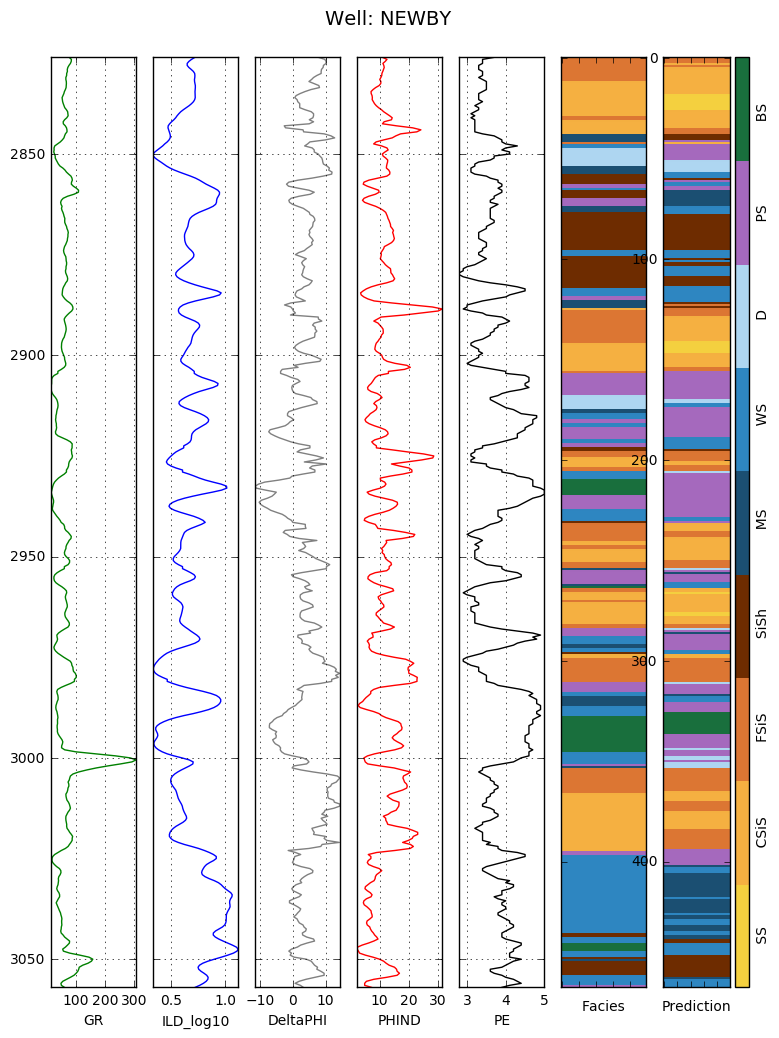

In [98]:
compare_facies_plot(blind, 'Prediction', facies_colors)

## Applying the classification model to new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels.  It is loaded into a dataframe called `test_data`.

In [112]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)


The data needs to be scaled using the same constants we used for the training data.

In [113]:
X_unknown = scaler.transform(well_features)

Finally we predict facies labels for the unknown data, and store the results in a `Facies` column of the `test_data` dataframe.

In [114]:
#predict facies of unclassified data
y_unknown = vtclf.predict(X_unknown)
vtclf.score(X_unknown)
well_data['Facies'] = y_unknown
well_data

TypeError: score() missing 1 required positional argument: 'y'

In [111]:
well_data['Well Name'].unique()

    Formation Well Name   Depth      GR  ILD_log10  DeltaPHI   PHIND     PE  \
0       A1 SH    STUART  2808.0  66.276      0.630     3.300  10.650  3.591   
1       A1 SH    STUART  2808.5  77.252      0.585     6.500  11.950  3.341   
2       A1 SH    STUART  2809.0  82.899      0.566     9.400  13.600  3.064   
3       A1 SH    STUART  2809.5  80.671      0.593     9.500  13.250  2.977   
4       A1 SH    STUART  2810.0  75.971      0.638     8.700  12.350  3.020   
..        ...       ...     ...     ...        ...       ...     ...    ...   
825      C SH  CRAWFORD  3158.5  86.078      0.554     5.040  16.150  3.161   
826      C SH  CRAWFORD  3159.0  88.855      0.539     5.560  16.750  3.118   
827      C SH  CRAWFORD  3159.5  90.490      0.530     6.360  16.780  3.168   
828      C SH  CRAWFORD  3160.0  90.975      0.522     7.035  16.995  3.154   
829      C SH  CRAWFORD  3160.5  90.108      0.513     7.505  17.595  3.125   

     NM_M  RELPOS  Facies FaciesLabels  
0       1 

[STUART, CRAWFORD]
Categories (2, object): [STUART, CRAWFORD]

We can use the well log plot to view the classification results along with the well logs.

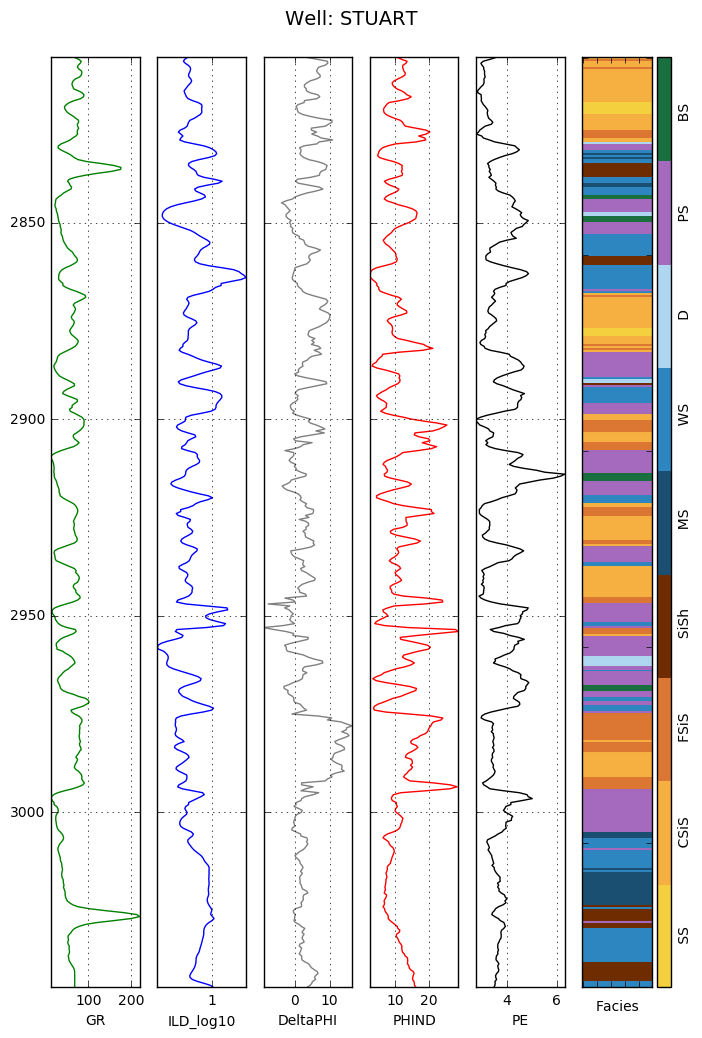

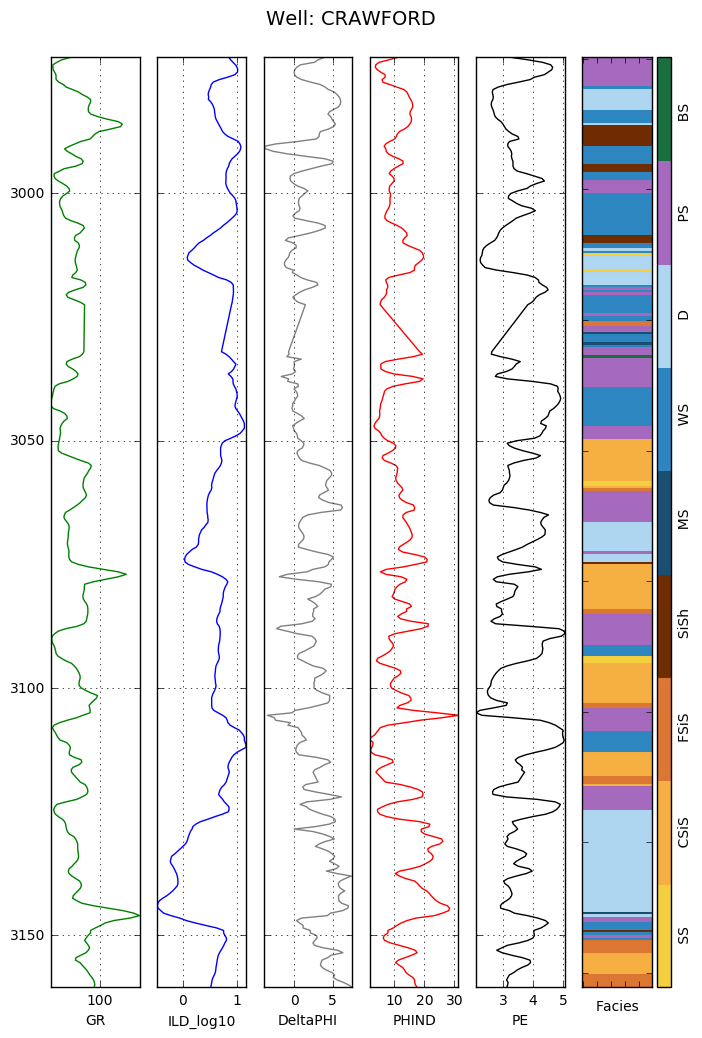

In [103]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

Finally we can write out a csv file with the well data along with the facies classification results.

In [104]:
well_data.to_csv('well_data_with_facies.csv')

## References

Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, 34 (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, *KGS Open-File Report* 2003-50, 6 pp. [pdf](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf)

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, *Computers & Geosciences*, 33 (5), 599-617 pp. [doi:10.1016/j.cageo.2006.08.011](http://dx.doi.org/10.1016/j.cageo.2006.08.011)